In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import (LinearRegression, RandomForestRegressor)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)
spark = SparkSession.builder.appName('Iteration_4').getOrCreate()

In [2]:
data = spark.read.csv("nzhealthsurvey2016.csv",inferSchema=True,header=True)

In [3]:
#data exploration
data.show()

+----------+-----------------+----+--------------+-----+------------+-------------+----+-----------+------------+------+-------------+--------------+----------------+-----------------------+------------------------+
|population|short.description|year|         group|total|total.low.CI|total.high.CI|male|male.low.CI|male.high.CI|female|female.low.CI|female.high.CI|estimated.number|estimated.number.low.CI|estimated.number.high.CI|
+----------+-----------------+----+--------------+-----+------------+-------------+----+-----------+------------+------+-------------+--------------+----------------+-----------------------+------------------------+
|    adults|Physically active|2011|         Total| 54.4|        51.8|         56.9|57.3|       54.6|        59.9|  51.7|         48.7|          54.7|         1899000|                1810000|                 1986000|
|    adults|Physically active|2011|         15-17| 58.1|        52.2|         63.7|61.1|       52.5|          69|  54.9|         45.8|  

In [4]:
data.printSchema()

root
 |-- population: string (nullable = true)
 |-- short.description: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- group: string (nullable = true)
 |-- total: double (nullable = true)
 |-- total.low.CI: double (nullable = true)
 |-- total.high.CI: double (nullable = true)
 |-- male: string (nullable = true)
 |-- male.low.CI: string (nullable = true)
 |-- male.high.CI: string (nullable = true)
 |-- female: string (nullable = true)
 |-- female.low.CI: string (nullable = true)
 |-- female.high.CI: string (nullable = true)
 |-- estimated.number: string (nullable = true)
 |-- estimated.number.low.CI: string (nullable = true)
 |-- estimated.number.high.CI: string (nullable = true)



In [5]:
data.head()

Row(population='adults', short.description='Physically active', year=2011, group='Total', total=54.4, total.low.CI=51.8, total.high.CI=56.9, male='57.3', male.low.CI='54.6', male.high.CI='59.9', female='51.7', female.low.CI='48.7', female.high.CI='54.7', estimated.number='1899000', estimated.number.low.CI='1810000', estimated.number.high.CI='1986000')

In [6]:
#trims for just anxiety
#anxiety =  data[522:624]
anxiety = spark.createDataFrame(data.head(619), data.schema)
tanxiety = spark.createDataFrame(anxiety.head(517), anxiety.schema)
anxiety = anxiety.subtract(tanxiety)
anxiety.show()

+----------+-----------------+----+----------+-----+------------+-------------+----+-----------+------------+------+-------------+--------------+----------------+-----------------------+------------------------+
|population|short.description|year|     group|total|total.low.CI|total.high.CI|male|male.low.CI|male.high.CI|female|female.low.CI|female.high.CI|estimated.number|estimated.number.low.CI|estimated.number.high.CI|
+----------+-----------------+----+----------+-----+------------+-------------+----+-----------+------------+------+-------------+--------------+----------------+-----------------------+------------------------+
|    adults| Anxiety disorder|2013|     35-44|  8.9|         7.4|         10.7| 7.5|        5.5|          10|  10.2|          8.2|          12.6|           52000|                  43000|                   63000|
|    adults| Anxiety disorder|2013|     Maori|  7.7|         6.3|          9.2| 5.1|        3.9|         6.8|   9.9|          7.8|          12.6|       

In [7]:
trimmedColumns = anxiety[['year', 'group','total', 'male', 'female']]
    
trimmedColumns.show()

+----+----------+-----+----+------+
|year|     group|total|male|female|
+----+----------+-----+----+------+
|2013|     35-44|  8.9| 7.5|  10.2|
|2013|     Maori|  7.7| 5.1|   9.9|
|2015|     Maori| 11.2| 8.2|  13.9|
|2014|     Asian|  2.0| 1.3|   2.7|
|2015|     45-54| 11.3| 9.5|    13|
|2015|     Asian|  2.1| 1.4|   2.9|
|2016|     15-24|  9.6| 6.6|  12.8|
|2016|     55-64| 10.4| 7.7|  12.8|
|2016|       75+|  7.8| 4.3|  10.6|
|2014|     15-24|  6.3| 3.6|   9.1|
|2014|       75+|  5.5| 2.9|   7.5|
|2016|Quintile 5| 12.3| 9.2|    15|
|2014|     35-44|  9.3| 6.2|  12.1|
|2012|     15-24|  5.2| 3.6|   6.9|
|2014|     55-64|  7.9|   5|  10.6|
|2015|     65-74|  8.9| 6.4|  11.2|
|2016|     65-74|  9.3| 6.8|  11.6|
|2016|     Asian|  2.8| 2.3|   3.4|
|2013|     15-24|  5.8| 4.3|   7.4|
|2013|     25-34|  7.9| 5.9|   9.9|
+----+----------+-----+----+------+
only showing top 20 rows



In [8]:
# Show only anxiety data we care about - regex pattern match "numeric*2-numeric*2" on group
anxiety = trimmedColumns.filter(trimmedColumns["group"].rlike("[0-9]{2}-[0-9]{2}"))

anxiety.show()

+----+-----+-----+----+------+
|year|group|total|male|female|
+----+-----+-----+----+------+
|2013|35-44|  8.9| 7.5|  10.2|
|2015|45-54| 11.3| 9.5|    13|
|2016|15-24|  9.6| 6.6|  12.8|
|2016|55-64| 10.4| 7.7|  12.8|
|2014|15-24|  6.3| 3.6|   9.1|
|2014|35-44|  9.3| 6.2|  12.1|
|2012|15-24|  5.2| 3.6|   6.9|
|2014|55-64|  7.9|   5|  10.6|
|2015|65-74|  8.9| 6.4|  11.2|
|2016|65-74|  9.3| 6.8|  11.6|
|2013|15-24|  5.8| 4.3|   7.4|
|2013|25-34|  7.9| 5.9|   9.9|
|2015|35-44| 11.1|   8|    14|
|2011|35-44|  7.9| 6.3|   9.3|
|2015|25-34| 10.2| 6.3|    14|
|2014|45-54|  8.8| 7.6|   9.8|
|2015|55-64|  8.4| 5.5|    11|
|2011|65-74|  5.5| 3.3|   7.6|
|2012|25-34|  7.5| 5.4|   9.6|
|2014|65-74|  6.8|   4|   9.3|
+----+-----+-----+----+------+
only showing top 20 rows



In [9]:
data1 = spark.read.csv("2006 anxiety.csv",inferSchema=True,header=True)

data1 = data1[['year', 'group', 'total', 'male', 'female']]
data1 = data1.filter(data1["group"].rlike("[0-9]{2}-[0-9]{2}"))

data1.show()

+----+-----+-----+----+------+
|year|group|total|male|female|
+----+-----+-----+----+------+
|2006|15-24|  2.6| 2.3|   3.0|
|2006|25-34|  4.6| 3.9|   5.3|
|2006|35-44|  5.7| 4.3|   7.0|
|2006|45-54|  3.9| 3.1|   4.8|
|2006|55-64|  4.8| 4.4|   5.2|
|2006|65-74|  4.5| 3.1|   5.8|
|2007|15-24|  9.5| 7.0|  12.0|
|2007|25-34|  6.9| 6.3|   7.5|
|2007|35-44|  6.4| 5.4|   7.4|
|2007|45-54|  5.1| 5.2|   5.0|
|2007|55-64|  4.8| 4.1|   5.5|
|2007|65-74|  5.2| 5.6|   4.9|
|2008|15-24|  5.0| 3.9|   6.2|
|2008|25-34|  5.3| 3.8|   6.6|
|2008|35-44|  5.0| 4.1|   5.8|
|2008|45-54|  4.6| 3.8|   5.3|
|2008|55-64|  3.8| 3.0|   4.4|
|2008|65-74|  3.5| 3.2|   3.8|
|2009|15-24|  6.8| 6.2|   7.5|
|2009|25-34|  6.6| 6.4|   6.7|
+----+-----+-----+----+------+
only showing top 20 rows



In [10]:
concat = data1.union(anxiety)

from pyspark.sql.functions import col

averages = [col('male'), col('female')]

averageFunc = sum(x for x in averages)/len(averages)

concat = concat.withColumn('avg(male-female)', averageFunc)

concat.show()

+----+-----+-----+----+------+-----------------+
|year|group|total|male|female| avg(male-female)|
+----+-----+-----+----+------+-----------------+
|2006|15-24|  2.6| 2.3|   3.0|             2.65|
|2006|25-34|  4.6| 3.9|   5.3|              4.6|
|2006|35-44|  5.7| 4.3|   7.0|             5.65|
|2006|45-54|  3.9| 3.1|   4.8|             3.95|
|2006|55-64|  4.8| 4.4|   5.2|4.800000000000001|
|2006|65-74|  4.5| 3.1|   5.8|             4.45|
|2007|15-24|  9.5| 7.0|  12.0|              9.5|
|2007|25-34|  6.9| 6.3|   7.5|              6.9|
|2007|35-44|  6.4| 5.4|   7.4|              6.4|
|2007|45-54|  5.1| 5.2|   5.0|              5.1|
|2007|55-64|  4.8| 4.1|   5.5|              4.8|
|2007|65-74|  5.2| 5.6|   4.9|             5.25|
|2008|15-24|  5.0| 3.9|   6.2|             5.05|
|2008|25-34|  5.3| 3.8|   6.6|5.199999999999999|
|2008|35-44|  5.0| 4.1|   5.8|4.949999999999999|
|2008|45-54|  4.6| 3.8|   5.3|             4.55|
|2008|55-64|  3.8| 3.0|   4.4|              3.7|
|2008|65-74|  3.5| 3

In [11]:
pandas_df = concat.toPandas()
pandas_df['male'] = pd.to_numeric(pandas_df['male'])
pandas_df['female'] = pd.to_numeric(pandas_df['female'])
pandas_df.info()
print(pandas_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 6 columns):
year                67 non-null int64
group               67 non-null object
total               67 non-null float64
male                67 non-null float64
female              67 non-null float64
avg(male-female)    67 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.2+ KB
    year  group  total  male  female  avg(male-female)
0   2006  15-24    2.6   2.3     3.0              2.65
1   2006  25-34    4.6   3.9     5.3              4.60
2   2006  35-44    5.7   4.3     7.0              5.65
3   2006  45-54    3.9   3.1     4.8              3.95
4   2006  55-64    4.8   4.4     5.2              4.80
5   2006  65-74    4.5   3.1     5.8              4.45
6   2007  15-24    9.5   7.0    12.0              9.50
7   2007  25-34    6.9   6.3     7.5              6.90
8   2007  35-44    6.4   5.4     7.4              6.40
9   2007  45-54    5.1   5.2     5.0             

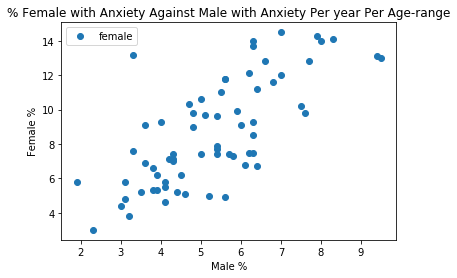

In [12]:
pandas_df.plot(x='male', y='female', style='o')
plt.title('% Female with Anxiety Against Male with Anxiety Per year Per Age-range')
plt.xlabel('Male %')
plt.ylabel('Female %')
plt.show()
    

In [13]:

assembler = VectorAssembler(
  inputCols=['year',
            'total',
            'male',
            'female',
            'avg(male-female)'],
              outputCol="features")

concat1 = concat.withColumn("male", concat["male"].cast('float'))
concat1 = concat1.withColumn("female", concat1["female"].cast('float'))

output = assembler.transform(concat1)

final_data = output.select("features",'avg(male-female)')


train_data,test_data = final_data.randomSplit([0.7,0.3])
# We can also use the multinomial family for binary classification

lr = LinearRegression(labelCol='avg(male-female)')
lrModel = lr.fit(train_data)
print("Coefficients: {} \n Intercept: {}".format(lrModel.coefficients,lrModel.intercept))
test_results = lrModel.evaluate(test_data)
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))
print("R2: {}".format(test_results.r2))
unlabeled_data = test_data.select('features')
unlabeled_data.show()
predictions = lrModel.transform(unlabeled_data)
predictions.show()
predictions.head(1)

Coefficients: [1.7843009427010172e-09,1.0206519648796634e-08,0.2184024042140399,0.2184023913959031,0.5631951898953775] 
 Intercept: -3.556818954201465e-06
+--------------------+
|           residuals|
+--------------------+
|-1.49732368726063...|
|3.797171643782349E-8|
|-7.20333925841032...|
|-2.30675789580914...|
|-2.86856476350294...|
|-1.52743320214199...|
|4.440854528553473E-8|
|-6.28221474840984...|
|2.248667563264916...|
|4.106959483607397...|
|6.142248132334771E-8|
|2.119180741999571...|
|-5.17592670945532...|
| 4.97597127946392E-8|
|4.605607273333589...|
|-7.20532788989203...|
|5.025160998428646E-8|
|5.332365837773523E-8|
|1.138818177537359...|
|-2.90385848700225...|
+--------------------+
only showing top 20 rows

RSME: 4.2883797466464135e-08
R2: 0.9999999999999997
+--------------------+
|            features|
+--------------------+
|[2006.0,3.9,3.099...|
|[2007.0,5.1,5.199...|
|[2008.0,3.5,3.200...|
|[2008.0,3.8,3.0,4...|
|[2008.0,4.6,3.799...|
|[2008.0,5.0,4.099...|
|[2008.0

[Row(features=DenseVector([2006.0, 3.9, 3.1, 4.8, 3.95]), prediction=3.950000014973237)]

In [18]:
#Random forest 



# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.

assembler = VectorAssembler(
  inputCols=['year',
            'total',
            'male',
            'female',
            'avg(male-female)'],
              outputCol="features")
concat = concat.withColumn("male", concat["male"].cast('float'))
concat = concat.withColumn("female", concat["female"].cast('float'))

output = assembler.transform(concat)

final_data = output.select("features",'avg(male-female)')


featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(final_data)

train_data,test_data = final_data.randomSplit([0.7,0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "group", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="group", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

IllegalArgumentException: 'Field "label" does not exist.'

In [ ]:
#Decision Tree 
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Load the data stored in LIBSVM format as a DataFrame.
data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)